## GeometricErrors - Point Shifting 

For KDD 2021

### Part 1: Loading Data

In [1]:
""" Environment Configuration """

# Source of input tensors. 
data_path = '/data/GeometricErrors/EM'

# Source of original rasters, shapefiles.
source_path ='/data/GeometricErrors/Scene01'

# Label of dataset used (Original = 1, New = 2)
dataset_label = 1

# Path to save EM Test as folder
out_root_dir = '/data/GeometricErrors/tests'

# Enables training with GPU
use_gpu = True
gpus = ['/gpu:0', '/gpu:1', '/gpu:2', '/gpu:3']

# Environment Seeds
tf_seed = 2001 # Tensorflow
np_seed = 2001 # Numpy
py_seed = 2001 # Python

# Pre-Load Determiner.
preload = False
#   ^^^
# - True, the candidates are loaded and stored. 
# - False, the candidates are loaded from jupyter persistent storage




# Weights to load when skipping training
std_weight_path = '/data/GeometricErrors/tests/BaselineWeights.h5'


""" Point Shifting Annotator Configuration """

# number of points to generate on BOTH sides of each source point
pairs = 15

# Interval at which shifting vertices are sampled in meters
interval = 10

# Offset distance between coordinate points as they are generated on either side of the source. (meters)
off_dist = 1.5

# Minimum Valid Proability over map
min_probability = 1e-06

# Weight consideration candidate0 line distance between candidate points
length_weight_value = 0

# Buffer in meters to apply to candidates
weight_buffer = 2

buff_dist = 4
# Option to normalize over K^2 (True) or by K (False).
normalize_full = False


""" UNET Config """

# Base learning rate to use in training. Reccomend 0.01
learning_rate = 0.01




""" EM Iteration Config """

# Initial jump-start predicted class map path
seg_class_map_fp = '/data/pmap.tif'

# Number of EM iterations
em_target = 6


# Learning Rate Scheduler
import lib.K_Tools as kt 
lr_schedule = kt.Oscillate_LR

# Optionally Enable notes
prompt_notes = False


/home/jiang-ws1/.virtualenvs/geo_errors/lib/python3.7/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.8.1-CAPI-1.13.3). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


In [2]:
# Std Imports
import os, sys, time, random, csv
from datetime import datetime as dt 

# Module Imports
import tensorflow as tf
import numpy as np
import rasterio as rio
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely.geometry as shp
from tensorflow.keras.optimizers import Adam

# Lib imports
import lib.Doc_Tools as doc
import lib.GeoTools as gt
import lib.Tiling as tile
import lib.K_Tools as kt
from lib.Annotators import *

""" Static Configuration """
# Batch size for training
batch_size = 32
# Early Stopping Patience
es_patience = 20
# Reduce Learning Rate on Plateau: Multiplier to reduce LR by upon plateau
rlop_factor = 0.5
# Adam Optimizer config
adam_epsilon = 1e-8
adam_decay = 1e-5
# Buffer in meters applied to annotations when comparing iou
iou_buffer = 6

# Seed environment
random.seed(py_seed)
tf.random.set_seed(tf_seed)
np.random.seed(np_seed)

# Prompt for notes on test
if prompt_notes:
    test_notes = input("Enter Notes for test: ")
else:
    test_notes = 'Notes have been disabled.'
    
### Create Folder for test documentation
test_idx, test_dir = doc.InitTest(out_root_dir,
                                  em_target=em_target,
                                  LR=learning_rate,
                                  notes=test_notes,
                                  pairs=pairs,
                                  interval=interval,
                                  off_distance=off_dist,
                                  min_p=min_probability,
                                  L=length_weight_value)

### Loading Source
train_raster = rio.open('{}/train_raster.tif'.format(source_path))
test_raster = rio.open('{}/test_raster.tif'.format(source_path))
template_raster = rio.open('{}/template_map.tif'.format(source_path))

gt_labels = gpd.read_file('{}/GroundTruth.shp'.format(source_path))
imp_labels = gpd.read_file('{}/imperfectLines.shp'.format(source_path))

### Loading Tensors
X_train = np.load('{}/X_train.npy'.format(data_path))
Y_train = np.load('{}/Y_train.npy'.format(data_path))

X_val = np.load('{}/X_val.npy'.format(data_path))
Y_val = np.load('{}/Y_val.npy'.format(data_path))

X_test = np.load('{}/X_test.npy'.format(data_path))
Y_test = np.load('{}/Y_test.npy'.format(data_path))


### Loading tile offsets
train_offsets_fp = '{}/train_offsets.csv'.format(data_path)
val_offsets_fp = '{}/val_offsets.csv'.format(data_path)
print("Successfully loaded tensors.")

# Convert All CRS's
imp_labels = imp_labels.to_crs(train_raster.crs)
gt_labels = gt_labels.to_crs(imp_labels.crs)
source_annotation = imp_labels

### Evaluate original Shapefile Precision
source_iou = gt.gdf_iou(gt_labels, imp_labels, iou_buffer)
prev_iou = source_iou

### Create A distributed training strategy for GPU training
if use_gpu:
    mirror_strategy = tf.distribute.MirroredStrategy(devices=gpus)

Successfully loaded tensors.
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0', '/job:localhost/replica:0/task:0/device:GPU:1', '/job:localhost/replica:0/task:0/device:GPU:2', '/job:localhost/replica:0/task:0/device:GPU:3')


In [3]:
weight_buffer = 4

### Part 1: Baseline Model Training and Evaluation


Preparing UNET model...
UNET model built successfully.
Epoch 1/50
INFO:tensorflow:batch_all_reduce: 90 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 90 all-reduces with algorithm = nccl, num_packs = 1
88/88 [==============================] - 16s 182ms/step - f1_score: 0.1517 - loss: -0.1440 - dice_coef: 0.1438 - accuracy: 0.8635 - val_f1_score: 0.0298 - val_loss: -0.0298 - val_dice_coef: 0.0298 - val_accuracy: 0.0202 - lr: 0.0100
Epoch 2/50
88/88 [==============================] - 12s 141ms/step - f1_score: 0.1984 - loss: -0.1973 - dice_coef: 0.1980 - accuracy: 0.9168 - val_f1_score: 0.0598 - val_loss: -0.0598 - val_dice_coef: 0.0598 - val_accuracy: 0.7997 - lr: 0.0100
Epoch 3/50
88/88 [==============================] - 13s 142ms/step - f1_score: 0.2041 - loss: -0.2038 - dice_coef: 0.2040 - accuracy: 0.9183 - val_f1_score: 0.0622 - val_loss: -0.1226 - val_dice_coef: 0.1226 - val_accuracy: 0.9320 - lr: 0.0100
Epoch 4/50
88/88 [=======================

Epoch 34/50
88/88 [==============================] - 12s 134ms/step - f1_score: 0.3948 - loss: -0.3962 - dice_coef: 0.3948 - accuracy: 0.9358 - val_f1_score: 0.2065 - val_loss: -0.2694 - val_dice_coef: 0.2694 - val_accuracy: 0.9315 - lr: 0.0012


/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Baseline Preformance:
Training Report 00
 - F1_Score: 43.841
 - Dice_Score: 43.831
 - False_Positives: 145068400.000
 - False_Negatives: 696069100.000
 - Precision: 36.622
 - Recall: 54.606
 - Keras_Precision: 51.631
 - Keras_Recall: 18.198
Validation Report 00
 - F1_Score: 34.540
 - Dice_Score: 34.552
 - False_Positives: 8087500.000
 - False_Negatives: 44573100.000
 - Precision: 31.257
 - Recall: 38.595
 - Keras_Precision: 46.645
 - Keras_Recall: 13.691
Testing Report 00
 - F1_Score: 44.571
 - Dice_Score: 44.553
 - False_Positives: 10592000.000
 - False_Negatives: 6749900.000
 - Precision: 39.696
 - Recall: 50.811
 - Keras_Precision: 39.696
 - Keras_Recall: 50.811
 - Confusion Matrix: [[9792057  105920]
 [  67499   69724]]



Thu at 03:11:31PM


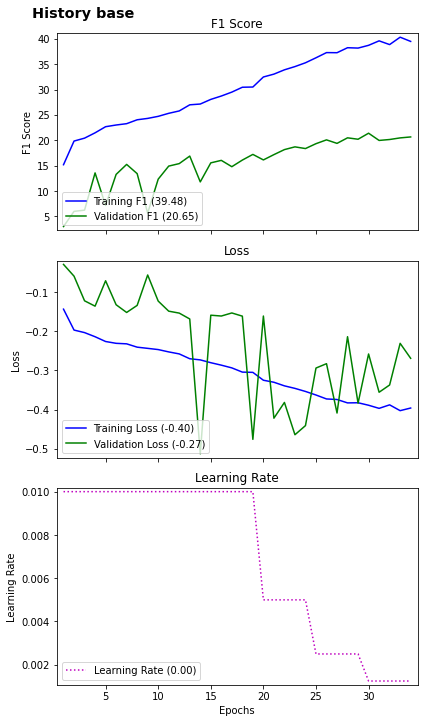

In [5]:
### Baseline Model Training
epochs = 50

# Get timer for baseline training
base_start = time.perf_counter()

# Prepare Baseline Folder
base_folder = os.path.join(test_dir, 'baseline')
if not os.path.exists(base_folder): os.mkdir(base_folder)

# Prepare tensorboard folder
base_tb_dir = os.path.join(base_folder, 'tensorboard')
    
# Prepare Callbacks, including weight output
base_callbacks = kt.SetCallbacks(weights_out=base_folder+'/BaselineWeights.h5', es_patience = es_patience, rlop_factor = rlop_factor, tensorboard_path=base_tb_dir)
metrics = [kt.dice_coef,'accuracy', kt.f1_score]
    
if use_gpu:
    with mirror_strategy.scope():
        # Select and Build Model
        model = kt.Get_Model('UNET')
        model.compile(optimizer=Adam(lr=learning_rate, epsilon=adam_epsilon, decay=adam_decay), loss = kt.dice_coef_loss, metrics=metrics)

        # Train Model
        baseline_results = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=base_callbacks)
else:
    # Select and Build Model
    model = kt.Get_Model('UNET')
    model.compile(optimizer=Adam(lr=learning_rate, epsilon=adam_epsilon, decay=adam_decay), loss = kt.dice_coef_loss, metrics=metrics)

    # Train Model
    baseline_results = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=base_callbacks)

# Save History plot and csv
doc.plot_history(baseline_results, test_dir=base_folder, config_idx='base')

epochs_used = len(baseline_results.history['accuracy'])

    
""" Evaluate Baseline Model Preformance """
print("Baseline Preformance:")
train_rpt = kt.ModelReport(X_train, Y_train, model, 'Training')
val_rpt = kt.ModelReport(X_val, Y_val, model, 'Validation')
test_rpt = kt.ModelReport(X_test, Y_test, model, 'Testing')

print(dt.now().strftime('\n\n%a at %I:%M:%S%p'))


### Part 2: EM Iteration

`Warning`: By proceeding, the EM Iteration will use the model configured above with the parameters already set. Tune the baseline model above as many times as needed before proceeding.

#### Section 1: Configure EM Test with Annotator

In [8]:
seg_class_map_fp = None
preload = True

In [10]:
# Prepare annotator
annotator = Dynamic_Preloading_Annotator(pairs=pairs,                   # Number of pairs to be linearly generated on either side of the source point 
                                         off_dist=off_dist,             # Interval distance that each new pair is generated
                                         interval=interval,             # Inteval at which new candidate groups are generated
                                         min_p=min_probability,         # Minimum valid probability from class map
                                         L=length_weight_value,         # Weight for line distance
                                         weight_buffer=weight_buffer,   # Buffer to apply to candidates when weighting
                                         normalize_full=normalize_full, # Optionally normalize by K^2 instead of K
                                         )

#copy_anno = annotator

# Preload Candidate Data 
if preload:
    if seg_class_map_fp:
        initial_pmap = rio.open(seg_class_map_fp)
    else:
        initial_pmap = kt.Get_Pmap(source_raster=train_raster, pmodel=model, pmap_fp=None)
    print("PRELOADING")
    all_data = annotator.preload_candidates(source_annotation, initial_pmap)
    %store all_data
    #%store annotator
else:
    %store -r all_data
    #%store -r annotator
    
    # Check the annotators for equivalent configuration
    """bad_keys = []
    for key in ['pairs', 'off_dist', 'interval', 'min_p', 'L', 'weight_buffer', 'normalize_full']:
        if (getattr(annotator, key) != getattr(copy_anno, key)):
            bad_keys.append(key)
    if len(bad_keys) > 0:
        raise RuntimeError("Annotators have {} incompatible keys: {}\nCandidates must be regenerated. Configure this in the first block.".format(len(bad_keys),bad_keys))
    
    """
    print("Loaded candidate_data")
    
    
# Prepare performance storage
em_dict = {
    'Name': ['Base'],
    'Test_Data': [test_rpt],
    'Train_Data': [train_rpt],
    'Val_Data': [val_rpt],
    'Line_IoU': [np.round((source_iou*100), 2)],
    'Epochs': [epochs_used],
    'LR': [learning_rate],
    'Training_Time': ['{:.3f} s'.format(time.perf_counter() - base_start)],
    'Update_Time': ['NA'],
}

# Prepare EM iterator index.
EM_iterator = 0

# Prepare storage for top F1 and IoU
top_f1, top_f1_idx = 0, 0
top_iou, top_iou_idx = 0, 0


PRELOADING
Completed Line 0 of 68.

Completed Line 1 of 68.

Completed Line 2 of 68.

Completed Line 3 of 68.

Completed Line 4 of 68.

Completed Line 5 of 68.

Completed Line 6 of 68.

Completed Line 7 of 68.

Completed Line 8 of 68.

Completed Line 9 of 68.

Completed Line 10 of 68.

Completed Line 11 of 68.

Completed Line 12 of 68.

Completed Line 13 of 68.

Completed Line 14 of 68.

Completed Line 15 of 68.

Completed Line 16 of 68.

Completed Line 17 of 68.

Completed Line 18 of 68.

Completed Line 19 of 68.

Completed Line 20 of 68.

Completed Line 21 of 68.

Completed Line 22 of 68.

Completed Line 23 of 68.

Completed Line 24 of 68.

Completed Line 25 of 68.

Completed Line 26 of 68.

Completed Line 27 of 68.

Completed Line 28 of 68.

Completed Line 29 of 68.

Completed Line 30 of 68.

Completed Line 31 of 68.

Completed Line 32 of 68.

Completed Line 33 of 68.

Completed Line 34 of 68.

Completed Line 35 of 68.

Completed Line 36 of 68.

Completed Line 37 of 68.

Completed L

In [12]:
buff_dist = 4

#### Run EM Iteration

Beginning Iteration, Target steps: 6

EM Step 00 begun.
Thu at 07:39:49PM

Generated Predicted Class and Intermediate Feature Maps from previous model. (Step 00)
Thu at 07:40:13PM

Created New Annotation. (Step 00)
Thu at 07:42:42PM

Created Y_train (2792, 224, 224, 1) and Y_val (160, 224, 224, 1). (Step 00)
Thu at 07:42:46PM

New Learning Rate: 0.005000. (Step 00)
Preparing UNET model...
UNET model built successfully.

Training model...
INFO:tensorflow:batch_all_reduce: 90 all-reduces with algorithm = nccl, num_packs = 1
INFO:tensorflow:batch_all_reduce: 90 all-reduces with algorithm = nccl, num_packs = 1
Completed model Training. (Step 00)
Thu at 07:53:05PM


/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 01
 - F1_Score: 42.649
 - Dice_Score: 42.612
 - False_Positives: 21752100.000
 - False_Negatives: 4107300.000
 - Precision: 30.653
 - Recall: 70.068
 - Keras_Precision: 30.653
 - Keras_Recall: 70.068
 - Confusion Matrix: [[9680456  217521]
 [  41073   96150]]

Training Report 01
 - F1_Score: 57.450
 - Dice_Score: 57.437
 - False_Positives: 203776400.000
 - False_Negatives: 703164700.000
 - Precision: 48.897
 - Recall: 69.629
 - Keras_Precision: 61.377
 - Keras_Recall: 31.532
Validation Report 01
 - F1_Score: 35.196
 - Dice_Score: 35.196
 - False_Positives: 14409800.000
 - False_Negatives: 49088100.000
 - Precision: 32.001
 - Recall: 39.098
 - Keras_Precision: 47.613
 - Keras_Recall: 21.061

New Top F1: 42.65

New Top IoU: 18.09

EM Step (00) Complete on Thu at 07:53:29PM
- Annotation IoU:     18.09
	- Source Improvement: -0.16
	- Step Improvement:   -0.16

------ Times ---------------------
- Class Map Generation: 23.861 s
- Annotation Update:    140.447 s
- Model Traini

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 02
 - F1_Score: 40.778
 - Dice_Score: 40.767
 - False_Positives: 20523500.000
 - False_Negatives: 4951800.000
 - Precision: 29.940
 - Recall: 63.914
 - Keras_Precision: 29.940
 - Keras_Recall: 63.914
 - Confusion Matrix: [[9692742  205235]
 [  49518   87705]]

Training Report 02
 - F1_Score: 61.369
 - Dice_Score: 61.358
 - False_Positives: 187887500.000
 - False_Negatives: 688589000.000
 - Precision: 52.441
 - Recall: 73.961
 - Keras_Precision: 63.919
 - Keras_Recall: 32.586
Validation Report 02
 - F1_Score: 42.003
 - Dice_Score: 41.992
 - False_Positives: 12883200.000
 - False_Negatives: 47103900.000
 - Precision: 38.308
 - Recall: 46.486
 - Keras_Precision: 52.584
 - Keras_Recall: 23.273

New Top IoU: 20.08

EM Step (01) Complete on Thu at 08:05:03PM
- Annotation IoU:     20.08
	- Source Improvement: +1.83
	- Step Improvement:   +1.99

------ Times ---------------------
- Class Map Generation: 23.622 s
- Annotation Update:    142.153 s
- Model Training:       488.884 s

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 03
 - F1_Score: 41.287
 - Dice_Score: 41.274
 - False_Positives: 18911800.000
 - False_Negatives: 5233100.000
 - Precision: 30.981
 - Recall: 61.864
 - Keras_Precision: 30.981
 - Keras_Recall: 61.864
 - Confusion Matrix: [[9708859  189118]
 [  52331   84892]]

Training Report 03
 - F1_Score: 67.058
 - Dice_Score: 67.048
 - False_Positives: 133328600.000
 - False_Negatives: 699754400.000
 - Precision: 60.764
 - Recall: 74.805
 - Keras_Precision: 70.395
 - Keras_Recall: 31.180
Validation Report 03
 - F1_Score: 44.013
 - Dice_Score: 44.011
 - False_Positives: 10466500.000
 - False_Negatives: 48628000.000
 - Precision: 43.176
 - Recall: 44.883
 - Keras_Precision: 56.073
 - Keras_Recall: 21.553

New Top IoU: 20.67

EM Step (02) Complete on Thu at 08:17:06PM
- Annotation IoU:     20.67
	- Source Improvement: +2.42
	- Step Improvement:   +0.59

------ Times ---------------------
- Class Map Generation: 23.618 s
- Annotation Update:    141.359 s
- Model Training:       518.845 s

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 04
 - F1_Score: 42.936
 - Dice_Score: 42.938
 - False_Positives: 14307700.000
 - False_Negatives: 6059800.000
 - Precision: 34.877
 - Recall: 55.840
 - Keras_Precision: 34.877
 - Keras_Recall: 55.840
 - Confusion Matrix: [[9754900  143077]
 [  60598   76625]]

Training Report 04
 - F1_Score: 70.380
 - Dice_Score: 70.375
 - False_Positives: 105298500.000
 - False_Negatives: 705750600.000
 - Precision: 66.093
 - Recall: 75.261
 - Keras_Precision: 74.455
 - Keras_Recall: 30.307
Validation Report 04
 - F1_Score: 52.359
 - Dice_Score: 52.361
 - False_Positives: 7394400.000
 - False_Negatives: 48790700.000
 - Precision: 54.552
 - Recall: 50.336
 - Keras_Precision: 64.791
 - Keras_Recall: 21.807

New Top F1: 42.94

New Top IoU: 22.74

EM Step (03) Complete on Thu at 08:29:26PM
- Annotation IoU:     22.74
	- Source Improvement: +4.48
	- Step Improvement:   +2.07

------ Times ---------------------
- Class Map Generation: 23.786 s
- Annotation Update:    142.353 s
- Model Trainin

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 05
 - F1_Score: 42.814
 - Dice_Score: 42.813
 - False_Positives: 12736900.000
 - False_Negatives: 6515500.000
 - Precision: 36.136
 - Recall: 52.519
 - Keras_Precision: 36.136
 - Keras_Recall: 52.519
 - Confusion Matrix: [[9770608  127369]
 [  65155   72068]]

Training Report 05
 - F1_Score: 74.637
 - Dice_Score: 74.632
 - False_Positives: 83717300.000
 - False_Negatives: 703143900.000
 - Precision: 71.740
 - Recall: 77.778
 - Keras_Precision: 78.731
 - Keras_Recall: 30.591
Validation Report 05
 - F1_Score: 51.402
 - Dice_Score: 51.403
 - False_Positives: 6704700.000
 - False_Negatives: 48940300.000
 - Precision: 55.255
 - Recall: 48.051
 - Keras_Precision: 66.055
 - Keras_Recall: 21.047

New Top IoU: 23.80

EM Step (04) Complete on Thu at 08:43:06PM
- Annotation IoU:     23.80
	- Source Improvement: +5.54
	- Step Improvement:   +1.06

------ Times ---------------------
- Class Map Generation: 23.710 s
- Annotation Update:    143.614 s
- Model Training:       611.171 s
-

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 06
 - F1_Score: 44.643
 - Dice_Score: 44.634
 - False_Positives: 11703700.000
 - False_Negatives: 6415900.000
 - Precision: 38.434
 - Recall: 53.245
 - Keras_Precision: 38.434
 - Keras_Recall: 53.245
 - Confusion Matrix: [[9780940  117037]
 [  64159   73064]]

Training Report 06
 - F1_Score: 76.408
 - Dice_Score: 76.404
 - False_Positives: 71160300.000
 - False_Negatives: 704989100.000
 - Precision: 74.756
 - Recall: 78.135
 - Keras_Precision: 81.131
 - Keras_Recall: 30.265
Validation Report 06
 - F1_Score: 51.163
 - Dice_Score: 51.158
 - False_Positives: 7028400.000
 - False_Negatives: 49008600.000
 - Precision: 54.370
 - Recall: 48.314
 - Keras_Precision: 64.826
 - Keras_Recall: 20.905

New Top F1: 44.64

New Top IoU: 25.14

EM Step (05) Complete on Thu at 08:57:06PM
- Annotation IoU:     25.14
	- Source Improvement: +6.88
	- Step Improvement:   +1.34

------ Times ---------------------
- Class Map Generation: 24.012 s
- Annotation Update:    144.571 s
- Model Training

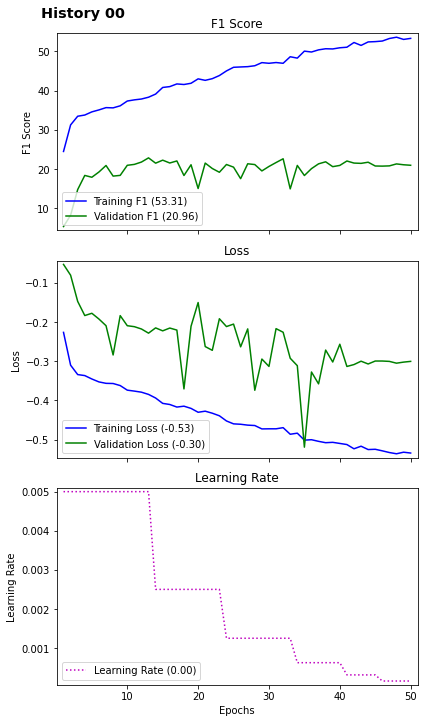

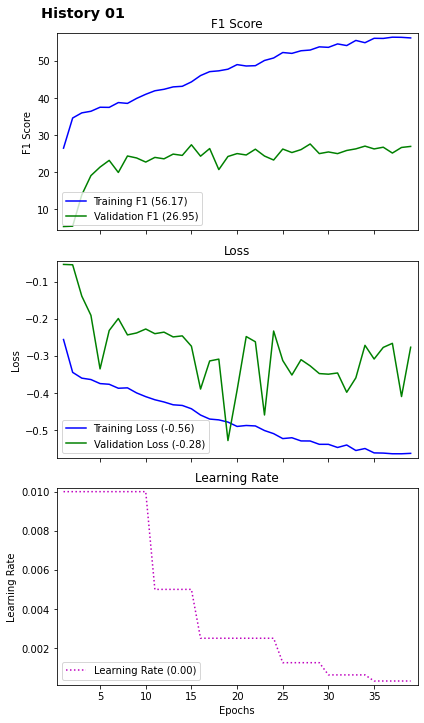

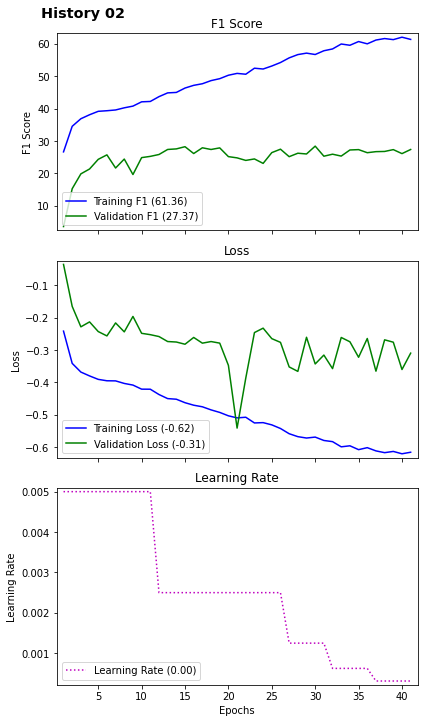

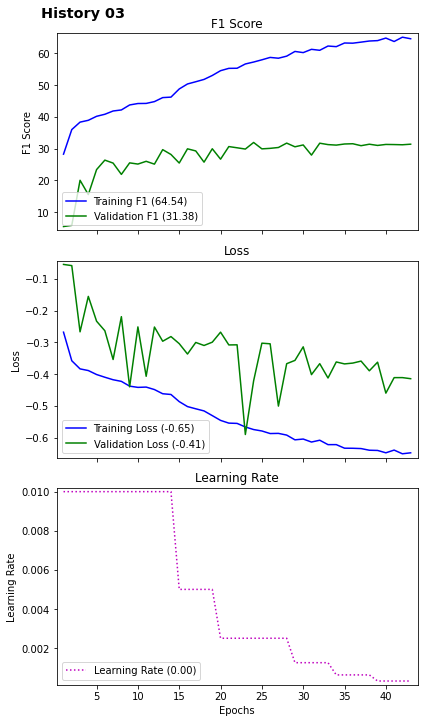

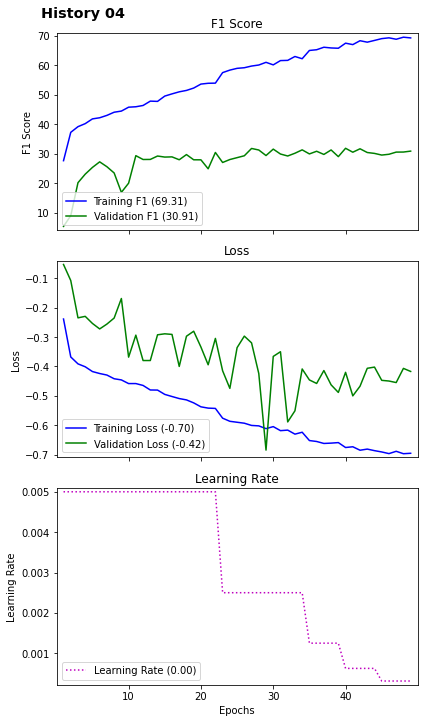

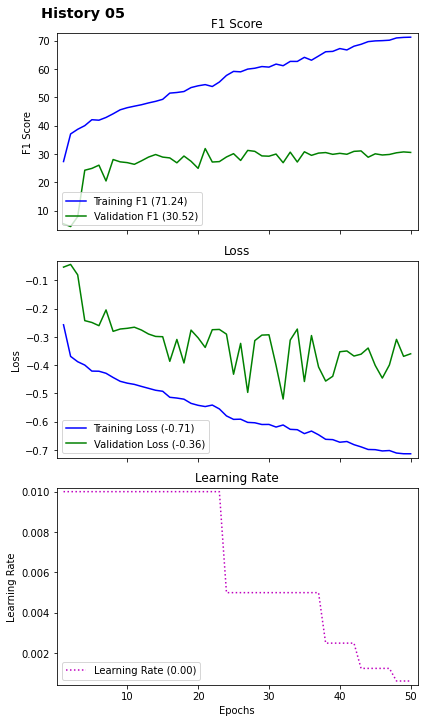

In [15]:
print("Beginning Iteration, Target steps:", em_target)
if EM_iterator > 0: print("Current Step:", EM_iterator)

# -----------------------------------------------------------------------------
# Begin Iteration -------------------------------------------------------------
while EM_iterator < em_target: # Note: using while loop to enable additional runs after test conclusion
    
    # 0. Initialization
    # ---------------------------
    step_start = time.perf_counter()

    # Create folder for em step
    emfolder = os.path.join(test_dir, 'Step_{:02}'.format(EM_iterator))
    if not os.path.exists(emfolder): os.mkdir(emfolder)

    print("\nEM Step {:02} begun.".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))

    
    # 1. Update Annotations
    # ---------------------------

    # 1.1 Get probability output map from last model 
    if (EM_iterator == 0) and seg_class_map_fp:
        # If on the first EM step, we load from previous data
        class_map_start = time.perf_counter()
        pmap_fp = os.path.join(emfolder, 'pmap_baseline.tif')
        kt.Get_Pmap(train_raster, model, pmap_fp)
        predicted_class_map = rio.open(seg_class_map_fp)
    else:
        # On every other EM step we take the pmap from the last model 
        class_map_start = time.perf_counter()
        pmap_fp = os.path.join(emfolder, 'pmap_{:02}.tif'.format(EM_iterator))
        predicted_class_map = kt.Get_Pmap(train_raster, model, pmap_fp)
        
    print("\nGenerated Predicted Class and Intermediate Feature Maps from previous model. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    
        
    # 1.2 Update annotation
    update_start = time.perf_counter()
    annotation_fp = os.path.join(emfolder, 'annotation_{:02}.shp'.format(EM_iterator))
    new_annotation = annotator.update_gdf_from_preload(all_data, class_map=predicted_class_map, out_path=annotation_fp) 

    # 1.3 Generate and save all considered point groups
    candidate_start = time.perf_counter()
    candidate_fp = os.path.join(emfolder, 'candidates_{:02}.shp'.format(EM_iterator))
    annotator.get_candidates(source_annotation, class_map=predicted_class_map, out_path=candidate_fp)
    
    # 1.5 Save iou for this annotation.
    iou_start = time.perf_counter()
    anno_iou = gt.gdf_iou(gt_labels, new_annotation, iou_buffer)


    print("\nCreated New Annotation. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))


    # 2. Create new Label Tensors
    # ---------------------------
    
    # 2.1 Rasterize New Labels
    rasterize_start = time.perf_counter()
    buff_anno = gt.gdf_buffer(new_annotation, buff_dist=buff_dist, flatten=True)
    anno_raster_fp = os.path.join(emfolder, 'rasterized_annotation_{:02}.tif'.format(EM_iterator))
    anno_raster = gt.GDF_Rasterize(buff_anno, train_raster, out_path=anno_raster_fp)
    
    # 2.2 Read Y_train, Y_val
    sample_tensor_start = time.perf_counter()
    Y_train = tile.ResampleTiles(anno_raster, train_offsets_fp)
    Y_val = tile.ResampleTiles(anno_raster, val_offsets_fp)
    
    # 2.2 Augment Y_train, Y_val
    Y_train = tile.AugmentImages(Y_train)
    Y_val = tile.AugmentImages(Y_val)
    
    print("\nCreated Y_train {} and Y_val {}. (Step {:02})".format(Y_train.shape, Y_val.shape, EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    
    
    # 3. Re-Train U-Net 
    # ---------------------------
    
    # 3.1 Load Callbacks 
    weight_path = os.path.join(emfolder, 'unet_weights_{:02}.h5'.format(EM_iterator))
    tensorboard_path = os.path.join(emfolder, 'tensorboard_{:02}'.format(EM_iterator))
    callbacks =  kt.SetCallbacks(weights_out = weight_path, es_patience = es_patience, rlop_factor = rlop_factor, tensorboard_path = tensorboard_path)#kt.SetCallbacks(emfolder + '/{}_{:02}.h5'.format(model_key, EM_iterator))
    
    # 3.2 Determine Learning Rate from internal oscilator
    EM_learning_rate = learning_rate #lr_schedule(learning_rate, EM_iterator, em_target)
    print("\nNew Learning Rate: {:.6f}. (Step {:02})".format(EM_learning_rate, EM_iterator))
    
    # 3.3 Train Model
    
    model_training_start = time.perf_counter()
    if use_gpu:
        with mirror_strategy.scope():
            model = kt.Get_Model('UNET')
            model.compile(optimizer=Adam(lr=EM_learning_rate, epsilon=adam_epsilon, decay=adam_decay), loss=kt.dice_coef_loss, metrics=metrics)
            print("\nTraining model...")
            training_history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=callbacks, verbose=0)
    else:
        model = kt.Get_Model('UNET')
        model.compile(optimizer=Adam(lr=EM_learning_rate, epsilon=adam_epsilon, decay=adam_decay), loss=kt.dice_coef_loss, metrics=metrics)
        print("\nTraining model...")
        training_history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=callbacks, verbose=0)
    
     
    
    print("Completed model Training. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    


    # 4. Evaluate Model
    # ---------------------------
    
    evaluate_start = time.perf_counter()

    # Save History Plots and CSV
    doc.plot_history(training_history, test_dir=emfolder, config_idx = EM_iterator)
    
    hist_markdown_fp = os.path.join(emfolder, 'history_{:02}.md'.format(EM_iterator))
    hist_md = open(hist_markdown_fp, 'w+')
    
    # Each of the reports below contains a dict with 'F1_Score', 'Dice' and their original floats
    test_rpt = kt.ModelReport(X_test, Y_test, model, "Testing", index=(EM_iterator+1), report_md=hist_md)
    train_rpt = kt.ModelReport(X_train, Y_train, model, "Training", index=(EM_iterator+1), report_md=hist_md)
    val_rpt = kt.ModelReport(X_val, Y_val, model, "Validation", index=(EM_iterator+1), report_md=hist_md)
    
    hist_md.close()
    
    evaluate_end = time.perf_counter()
    
    # Update reference dict
    em_dict['Name'].append('Step {:02}'.format(EM_iterator))
    em_dict['Line_IoU'].append(np.round((anno_iou*100), 2))
    
    em_dict['Test_Data'].append(test_rpt)
    em_dict['Train_Data'].append(train_rpt)
    em_dict['Val_Data'].append(val_rpt)
        
    em_dict['Epochs'].append(len(training_history.history['accuracy']))
    em_dict['LR'].append(EM_learning_rate)
    em_dict['Update_Time'].append('{:.3f} s'.format(candidate_start - update_start))
    em_dict['Training_Time'].append('{:.3f} s'.format(evaluate_start - model_training_start))
    
    
    # Update top values
    ### f1 score
    if test_rpt['F1_Score'] > top_f1:
        top_f1 = test_rpt['F1_Score']
        top_f1_idx = EM_iterator
        print("\nNew Top F1: {:.2f}".format(top_f1*100))
    ### Annotation IoU
    if np.round((anno_iou*100), 2) > top_iou:
        top_iou = np.round((anno_iou*100), 2)
        top_iou_idx = EM_iterator
        print("\nNew Top IoU: {:.2f}".format(top_iou))
    
    # Print step data
    print("\nEM Step ({:02}) Complete on {}".format(EM_iterator, dt.now().strftime('%a at %I:%M:%S%p')))
    print('- Annotation IoU:     {:.2f}'.format(anno_iou*100))
    print('\t- Source Improvement: {:+.2f}'.format((anno_iou-source_iou)*100))
    print('\t- Step Improvement:   {:+.2f}'.format((anno_iou-prev_iou)*100))
    print()
    print("------ Times ---------------------")
    print("- Class Map Generation: {:.3f} s".format(update_start - class_map_start))
    print("- Annotation Update:    {:.3f} s".format(candidate_start - update_start))
    print("- Model Training:       {:.3f} s".format(evaluate_start - model_training_start))
    print("- Model Evaluation:     {:.3f} s".format(evaluate_end - evaluate_start))
    print("----------------------------------\n\n")
    
    # Increase iterator and save previous precision for step_delta
    EM_iterator += 1
    prev_iou = anno_iou
 
# Increase EM target for optional subsequent runs
em_target += 1


Beginning Iteration, Target steps: 10
Current Step: 6

EM Step 06 begun.
Thu at 08:57:08PM

Generated Predicted Class and Intermediate Feature Maps from previous model. (Step 06)
Thu at 08:57:32PM

Created New Annotation. (Step 06)
Thu at 09:00:05PM

Created Y_train (2792, 224, 224, 1) and Y_val (160, 224, 224, 1). (Step 06)
Thu at 09:00:10PM

New Learning Rate: 0.010000. (Step 06)
Preparing UNET model...
UNET model built successfully.

Training model...
Completed model Training. (Step 06)
Thu at 09:10:38PM


/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 07
 - F1_Score: 45.101
 - Dice_Score: 45.091
 - False_Positives: 12207100.000
 - False_Negatives: 6172700.000
 - Precision: 38.213
 - Recall: 55.017
 - Keras_Precision: 38.213
 - Keras_Recall: 55.017
 - Confusion Matrix: [[9775906  122071]
 [  61727   75496]]

Training Report 07
 - F1_Score: 71.666
 - Dice_Score: 71.659
 - False_Positives: 94280600.000
 - False_Negatives: 709147400.000
 - Precision: 68.414
 - Recall: 75.243
 - Keras_Precision: 76.197
 - Keras_Recall: 29.854
Validation Report 07
 - F1_Score: 56.326
 - Dice_Score: 56.327
 - False_Positives: 6953600.000
 - False_Negatives: 47445400.000
 - Precision: 57.927
 - Recall: 54.812
 - Keras_Precision: 67.520
 - Keras_Recall: 23.353

New Top F1: 45.10

New Top IoU: 26.05

EM Step (06) Complete on Thu at 09:11:03PM
- Annotation IoU:     26.05
	- Source Improvement: +7.80
	- Step Improvement:   +0.92

------ Times ---------------------
- Class Map Generation: 23.934 s
- Annotation Update:    143.597 s
- Model Training

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 08
 - F1_Score: 45.518
 - Dice_Score: 45.509
 - False_Positives: 12290800.000
 - False_Negatives: 6057600.000
 - Precision: 38.409
 - Recall: 55.856
 - Keras_Precision: 38.409
 - Keras_Recall: 55.856
 - Confusion Matrix: [[9775069  122908]
 [  60576   76647]]

Training Report 08
 - F1_Score: 75.607
 - Dice_Score: 75.600
 - False_Positives: 74706700.000
 - False_Negatives: 707378200.000
 - Precision: 73.908
 - Recall: 77.386
 - Keras_Precision: 80.188
 - Keras_Recall: 29.945
Validation Report 08
 - F1_Score: 58.648
 - Dice_Score: 58.655
 - False_Positives: 5804000.000
 - False_Negatives: 47692000.000
 - Precision: 62.253
 - Recall: 55.437
 - Keras_Precision: 71.101
 - Keras_Recall: 23.042

New Top F1: 45.52

New Top IoU: 27.34

EM Step (07) Complete on Thu at 09:23:54PM
- Annotation IoU:     27.34
	- Source Improvement: +9.08
	- Step Improvement:   +1.29

------ Times ---------------------
- Class Map Generation: 23.688 s
- Annotation Update:    141.087 s
- Model Training

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 09
 - F1_Score: 49.413
 - Dice_Score: 49.399
 - False_Positives: 11275500.000
 - False_Negatives: 5519700.000
 - Precision: 42.112
 - Recall: 59.776
 - Keras_Precision: 42.112
 - Keras_Recall: 59.776
 - Confusion Matrix: [[9785222  112755]
 [  55197   82026]]

Training Report 09
 - F1_Score: 72.340
 - Dice_Score: 72.331
 - False_Positives: 91560300.000
 - False_Negatives: 707348900.000
 - Precision: 69.269
 - Recall: 75.697
 - Keras_Precision: 76.729
 - Keras_Recall: 29.912
Validation Report 09
 - F1_Score: 62.990
 - Dice_Score: 62.986
 - False_Positives: 5039200.000
 - False_Negatives: 47029000.000
 - Precision: 67.268
 - Recall: 59.223
 - Keras_Precision: 74.609
 - Keras_Recall: 23.946

New Top F1: 49.41

New Top IoU: 28.45

EM Step (08) Complete on Thu at 09:35:51PM
- Annotation IoU:     28.45
	- Source Improvement: +10.19
	- Step Improvement:   +1.11

------ Times ---------------------
- Class Map Generation: 24.463 s
- Annotation Update:    142.547 s
- Model Trainin

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 10
 - F1_Score: 49.035
 - Dice_Score: 49.027
 - False_Positives: 10443700.000
 - False_Negatives: 5872900.000
 - Precision: 42.909
 - Recall: 57.202
 - Keras_Precision: 42.909
 - Keras_Recall: 57.202
 - Confusion Matrix: [[9793540  104437]
 [  58729   78494]]

Training Report 10
 - F1_Score: 74.864
 - Dice_Score: 74.857
 - False_Positives: 77510600.000
 - False_Negatives: 708148800.000
 - Precision: 73.095
 - Recall: 76.721
 - Keras_Precision: 79.506
 - Keras_Recall: 29.806
Validation Report 10
 - F1_Score: 59.366
 - Dice_Score: 59.359
 - False_Positives: 5051100.000
 - False_Negatives: 47735700.000
 - Precision: 65.145
 - Recall: 54.528
 - Keras_Precision: 72.788
 - Keras_Recall: 22.060

New Top IoU: 29.80

EM Step (09) Complete on Thu at 09:48:12PM
- Annotation IoU:     29.80
	- Source Improvement: +11.54
	- Step Improvement:   +1.35

------ Times ---------------------
- Class Map Generation: 23.938 s
- Annotation Update:    142.692 s
- Model Training:       532.258 s


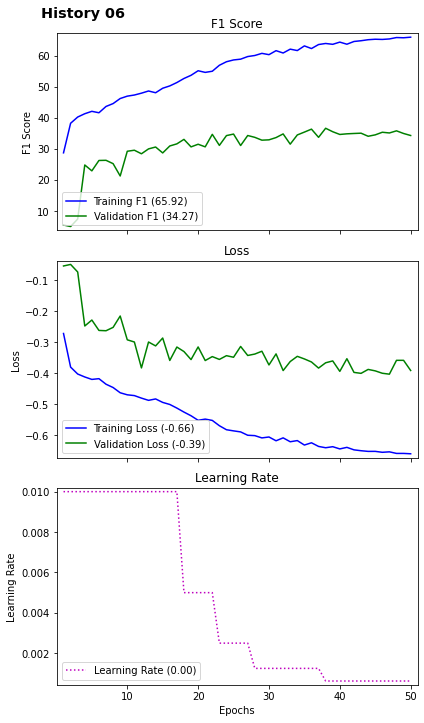

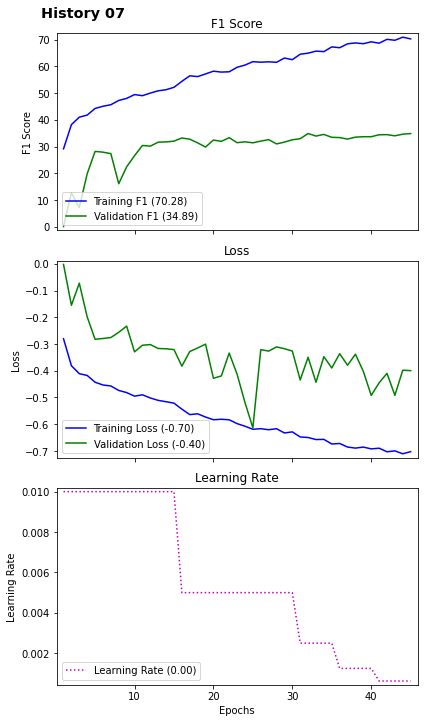

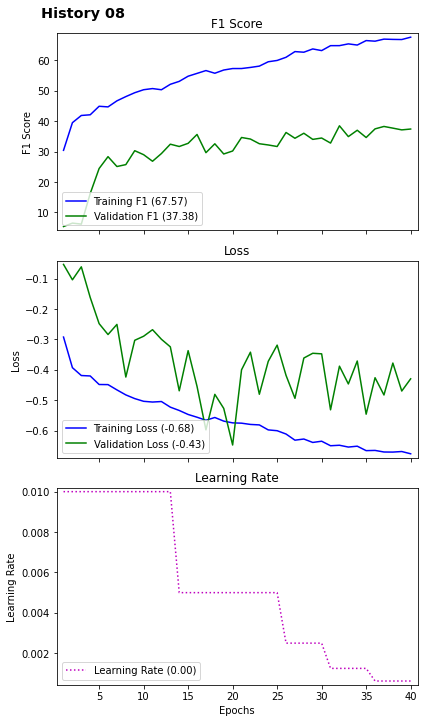

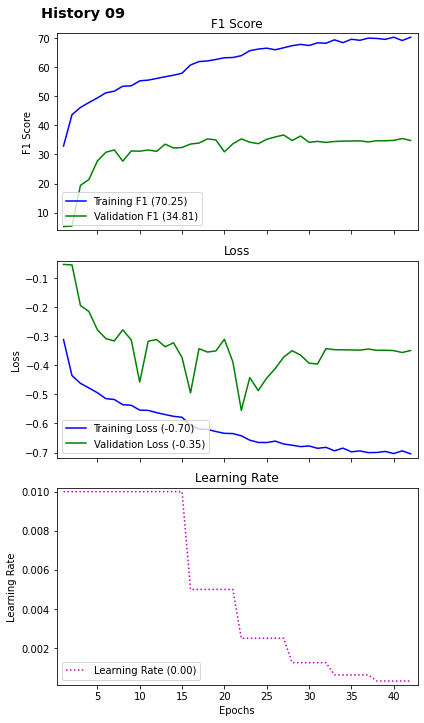

In [16]:
em_target = 10

print("Beginning Iteration, Target steps:", em_target)
if EM_iterator > 0: print("Current Step:", EM_iterator)

# -----------------------------------------------------------------------------
# Begin Iteration -------------------------------------------------------------
while EM_iterator < em_target: # Note: using while loop to enable additional runs after test conclusion
    
    # 0. Initialization
    # ---------------------------
    step_start = time.perf_counter()

    # Create folder for em step
    emfolder = os.path.join(test_dir, 'Step_{:02}'.format(EM_iterator))
    if not os.path.exists(emfolder): os.mkdir(emfolder)

    print("\nEM Step {:02} begun.".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))

    
    # 1. Update Annotations
    # ---------------------------

    # 1.1 Get probability output map from last model 
    if (EM_iterator == 0) and seg_class_map_fp:
        # If on the first EM step, we load from previous data
        class_map_start = time.perf_counter()
        pmap_fp = os.path.join(emfolder, 'pmap_baseline.tif')
        kt.Get_Pmap(train_raster, model, pmap_fp)
        predicted_class_map = rio.open(seg_class_map_fp)
    else:
        # On every other EM step we take the pmap from the last model 
        class_map_start = time.perf_counter()
        pmap_fp = os.path.join(emfolder, 'pmap_{:02}.tif'.format(EM_iterator))
        predicted_class_map = kt.Get_Pmap(train_raster, model, pmap_fp)
        
    print("\nGenerated Predicted Class and Intermediate Feature Maps from previous model. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    
        
    # 1.2 Update annotation
    update_start = time.perf_counter()
    annotation_fp = os.path.join(emfolder, 'annotation_{:02}.shp'.format(EM_iterator))
    new_annotation = annotator.update_gdf_from_preload(all_data, class_map=predicted_class_map, out_path=annotation_fp) 

    # 1.3 Generate and save all considered point groups
    candidate_start = time.perf_counter()
    candidate_fp = os.path.join(emfolder, 'candidates_{:02}.shp'.format(EM_iterator))
    annotator.get_candidates(source_annotation, class_map=predicted_class_map, out_path=candidate_fp)
    
    # 1.5 Save iou for this annotation.
    iou_start = time.perf_counter()
    anno_iou = gt.gdf_iou(gt_labels, new_annotation, iou_buffer)


    print("\nCreated New Annotation. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))


    # 2. Create new Label Tensors
    # ---------------------------
    
    # 2.1 Rasterize New Labels
    rasterize_start = time.perf_counter()
    buff_anno = gt.gdf_buffer(new_annotation, buff_dist=buff_dist, flatten=True)
    anno_raster_fp = os.path.join(emfolder, 'rasterized_annotation_{:02}.tif'.format(EM_iterator))
    anno_raster = gt.GDF_Rasterize(buff_anno, train_raster, out_path=anno_raster_fp)
    
    # 2.2 Read Y_train, Y_val
    sample_tensor_start = time.perf_counter()
    Y_train = tile.ResampleTiles(anno_raster, train_offsets_fp)
    Y_val = tile.ResampleTiles(anno_raster, val_offsets_fp)
    
    # 2.2 Augment Y_train, Y_val
    Y_train = tile.AugmentImages(Y_train)
    Y_val = tile.AugmentImages(Y_val)
    
    print("\nCreated Y_train {} and Y_val {}. (Step {:02})".format(Y_train.shape, Y_val.shape, EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    
    
    # 3. Re-Train U-Net 
    # ---------------------------
    
    # 3.1 Load Callbacks 
    weight_path = os.path.join(emfolder, 'unet_weights_{:02}.h5'.format(EM_iterator))
    tensorboard_path = os.path.join(emfolder, 'tensorboard_{:02}'.format(EM_iterator))
    callbacks =  kt.SetCallbacks(weights_out = weight_path, es_patience = es_patience, rlop_factor = rlop_factor, tensorboard_path = tensorboard_path)#kt.SetCallbacks(emfolder + '/{}_{:02}.h5'.format(model_key, EM_iterator))
    
    # 3.2 Determine Learning Rate from internal oscilator
    EM_learning_rate = learning_rate #lr_schedule(learning_rate, EM_iterator, em_target)
    print("\nNew Learning Rate: {:.6f}. (Step {:02})".format(EM_learning_rate, EM_iterator))
    
    # 3.3 Train Model
    
    model_training_start = time.perf_counter()
    if use_gpu:
        with mirror_strategy.scope():
            model = kt.Get_Model('UNET')
            model.compile(optimizer=Adam(lr=EM_learning_rate, epsilon=adam_epsilon, decay=adam_decay), loss=kt.dice_coef_loss, metrics=metrics)
            print("\nTraining model...")
            training_history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=callbacks, verbose=0)
    else:
        model = kt.Get_Model('UNET')
        model.compile(optimizer=Adam(lr=EM_learning_rate, epsilon=adam_epsilon, decay=adam_decay), loss=kt.dice_coef_loss, metrics=metrics)
        print("\nTraining model...")
        training_history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=callbacks, verbose=0)
    
     
    
    print("Completed model Training. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    


    # 4. Evaluate Model
    # ---------------------------
    
    evaluate_start = time.perf_counter()

    # Save History Plots and CSV
    doc.plot_history(training_history, test_dir=emfolder, config_idx = EM_iterator)
    
    hist_markdown_fp = os.path.join(emfolder, 'history_{:02}.md'.format(EM_iterator))
    hist_md = open(hist_markdown_fp, 'w+')
    
    # Each of the reports below contains a dict with 'F1_Score', 'Dice' and their original floats
    test_rpt = kt.ModelReport(X_test, Y_test, model, "Testing", index=(EM_iterator+1), report_md=hist_md)
    train_rpt = kt.ModelReport(X_train, Y_train, model, "Training", index=(EM_iterator+1), report_md=hist_md)
    val_rpt = kt.ModelReport(X_val, Y_val, model, "Validation", index=(EM_iterator+1), report_md=hist_md)
    
    hist_md.close()
    
    evaluate_end = time.perf_counter()
    
    # Update reference dict
    em_dict['Name'].append('Step {:02}'.format(EM_iterator))
    em_dict['Line_IoU'].append(np.round((anno_iou*100), 2))
    
    em_dict['Test_Data'].append(test_rpt)
    em_dict['Train_Data'].append(train_rpt)
    em_dict['Val_Data'].append(val_rpt)
        
    em_dict['Epochs'].append(len(training_history.history['accuracy']))
    em_dict['LR'].append(EM_learning_rate)
    em_dict['Update_Time'].append('{:.3f} s'.format(candidate_start - update_start))
    em_dict['Training_Time'].append('{:.3f} s'.format(evaluate_start - model_training_start))
    
    
    # Update top values
    ### f1 score
    if test_rpt['F1_Score'] > top_f1:
        top_f1 = test_rpt['F1_Score']
        top_f1_idx = EM_iterator
        print("\nNew Top F1: {:.2f}".format(top_f1*100))
    ### Annotation IoU
    if np.round((anno_iou*100), 2) > top_iou:
        top_iou = np.round((anno_iou*100), 2)
        top_iou_idx = EM_iterator
        print("\nNew Top IoU: {:.2f}".format(top_iou))
    
    # Print step data
    print("\nEM Step ({:02}) Complete on {}".format(EM_iterator, dt.now().strftime('%a at %I:%M:%S%p')))
    print('- Annotation IoU:     {:.2f}'.format(anno_iou*100))
    print('\t- Source Improvement: {:+.2f}'.format((anno_iou-source_iou)*100))
    print('\t- Step Improvement:   {:+.2f}'.format((anno_iou-prev_iou)*100))
    print()
    print("------ Times ---------------------")
    print("- Class Map Generation: {:.3f} s".format(update_start - class_map_start))
    print("- Annotation Update:    {:.3f} s".format(candidate_start - update_start))
    print("- Model Training:       {:.3f} s".format(evaluate_start - model_training_start))
    print("- Model Evaluation:     {:.3f} s".format(evaluate_end - evaluate_start))
    print("----------------------------------\n\n")
    
    # Increase iterator and save previous precision for step_delta
    EM_iterator += 1
    prev_iou = anno_iou
 
# Increase EM target for optional subsequent runs
em_target += 1


Beginning Iteration, Target steps: 14
Current Step: 10

EM Step 10 begun.
Fri at 09:58:41PM

Generated Predicted Class and Intermediate Feature Maps from previous model. (Step 10)
Fri at 09:59:06PM

Created New Annotation. (Step 10)
Fri at 10:01:37PM

Created Y_train (2792, 224, 224, 1) and Y_val (160, 224, 224, 1). (Step 10)
Fri at 10:01:42PM

New Learning Rate: 0.010000. (Step 10)
Preparing UNET model...
UNET model built successfully.

Training model...
Completed model Training. (Step 10)
Fri at 10:09:53PM


/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 11
 - F1_Score: 50.344
 - Dice_Score: 50.342
 - False_Positives: 3882800.000
 - False_Negatives: 7799900.000
 - Precision: 60.401
 - Recall: 43.159
 - Keras_Precision: 60.401
 - Keras_Recall: 43.159
 - Confusion Matrix: [[9859149   38828]
 [  77999   59224]]

Training Report 11
 - F1_Score: 63.501
 - Dice_Score: 63.494
 - False_Positives: 50836100.000
 - False_Negatives: 713930400.000
 - Precision: 65.406
 - Recall: 61.704
 - Keras_Precision: 73.627
 - Keras_Recall: 16.582
Validation Report 11
 - F1_Score: 51.943
 - Dice_Score: 51.935
 - False_Positives: 2572900.000
 - False_Negatives: 45868700.000
 - Precision: 62.611
 - Recall: 44.381
 - Keras_Precision: 71.664
 - Keras_Recall: 12.424

New Top F1: 50.34

New Top IoU: 31.07

EM Step (10) Complete on Fri at 10:10:20PM
- Annotation IoU:     31.07
	- Source Improvement: +12.81
	- Step Improvement:   +1.27

------ Times ---------------------
- Class Map Generation: 24.730 s
- Annotation Update:    142.628 s
- Model Training

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 12
 - F1_Score: 60.342
 - Dice_Score: 60.346
 - False_Positives: 4353500.000
 - False_Negatives: 5912300.000
 - Precision: 64.208
 - Recall: 56.915
 - Keras_Precision: 64.208
 - Keras_Recall: 56.915
 - Confusion Matrix: [[9854442   43535]
 [  59123   78100]]

Training Report 12
 - F1_Score: 64.402
 - Dice_Score: 64.400
 - False_Positives: 53886100.000
 - False_Negatives: 707344000.000
 - Precision: 64.890
 - Recall: 63.921
 - Keras_Precision: 73.430
 - Keras_Recall: 17.392
Validation Report 12
 - F1_Score: 52.845
 - Dice_Score: 52.854
 - False_Positives: 3182700.000
 - False_Negatives: 45609900.000
 - Precision: 60.085
 - Recall: 47.162
 - Keras_Precision: 68.743
 - Keras_Recall: 13.305

New Top F1: 60.34

New Top IoU: 31.94

EM Step (11) Complete on Fri at 10:21:21PM
- Annotation IoU:     31.94
	- Source Improvement: +13.68
	- Step Improvement:   +0.87

------ Times ---------------------
- Class Map Generation: 25.380 s
- Annotation Update:    142.590 s
- Model Training

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 13
 - F1_Score: 57.351
 - Dice_Score: 57.346
 - False_Positives: 4487600.000
 - False_Negatives: 6401200.000
 - Precision: 61.998
 - Recall: 53.352
 - Keras_Precision: 61.998
 - Keras_Recall: 53.352
 - Confusion Matrix: [[9853101   44876]
 [  64012   73211]]

Training Report 13
 - F1_Score: 70.078
 - Dice_Score: 70.072
 - False_Positives: 42027800.000
 - False_Negatives: 700049900.000
 - Precision: 71.590
 - Recall: 68.629
 - Keras_Precision: 78.404
 - Keras_Recall: 17.895
Validation Report 13
 - F1_Score: 53.761
 - Dice_Score: 53.746
 - False_Positives: 2877200.000
 - False_Negatives: 45613800.000
 - Precision: 62.222
 - Recall: 47.325
 - Keras_Precision: 70.710
 - Keras_Recall: 13.215

New Top IoU: 33.11

EM Step (12) Complete on Fri at 10:31:39PM
- Annotation IoU:     33.11
	- Source Improvement: +14.85
	- Step Improvement:   +1.17

------ Times ---------------------
- Class Map Generation: 24.089 s
- Annotation Update:    141.124 s
- Model Training:       412.287 s
-

/home/jiang-ws1/GeometricErrors/lib/Doc_Tools.py:368: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  hist_fig.show()


Testing Report 14
 - F1_Score: 48.976
 - Dice_Score: 48.973
 - False_Positives: 3510500.000
 - False_Negatives: 8133900.000
 - Precision: 61.418
 - Recall: 40.725
 - Keras_Precision: 61.418
 - Keras_Recall: 40.725
 - Confusion Matrix: [[9862872   35105]
 [  81339   55884]]

Training Report 14
 - F1_Score: 72.613
 - Dice_Score: 72.604
 - False_Positives: 35277300.000
 - False_Negatives: 697948700.000
 - Precision: 75.195
 - Recall: 70.203
 - Keras_Precision: 81.241
 - Keras_Recall: 17.958
Validation Report 14
 - F1_Score: 59.928
 - Dice_Score: 59.926
 - False_Positives: 2184800.000
 - False_Negatives: 45041400.000
 - Precision: 69.941
 - Recall: 52.424
 - Keras_Precision: 77.168
 - Keras_Recall: 14.085

New Top IoU: 33.46

EM Step (13) Complete on Fri at 10:44:20PM
- Annotation IoU:     33.46
	- Source Improvement: +15.20
	- Step Improvement:   +0.36

------ Times ---------------------
- Class Map Generation: 23.850 s
- Annotation Update:    141.428 s
- Model Training:       557.302 s
-

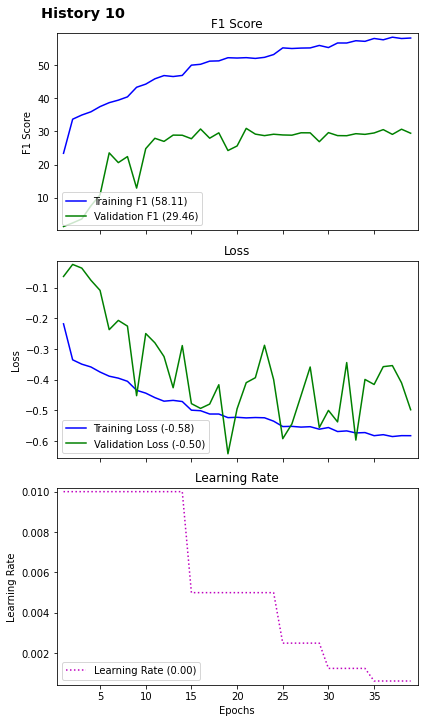

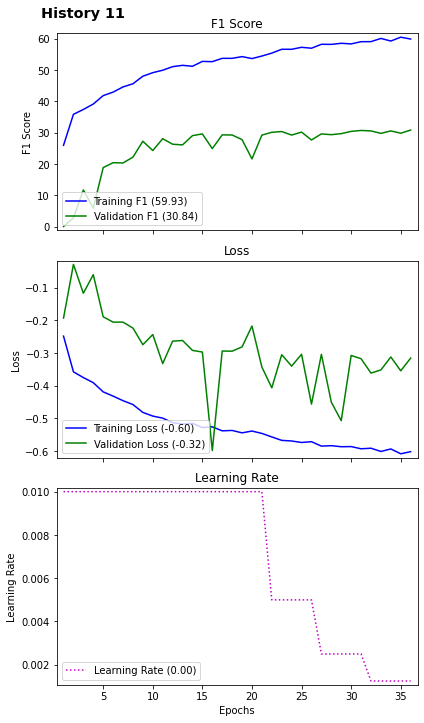

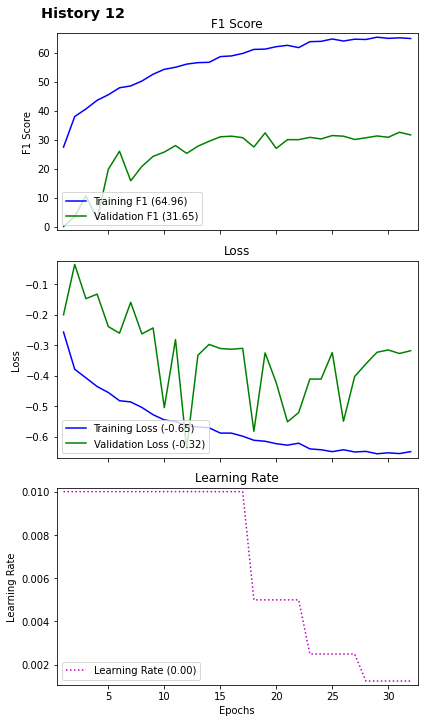

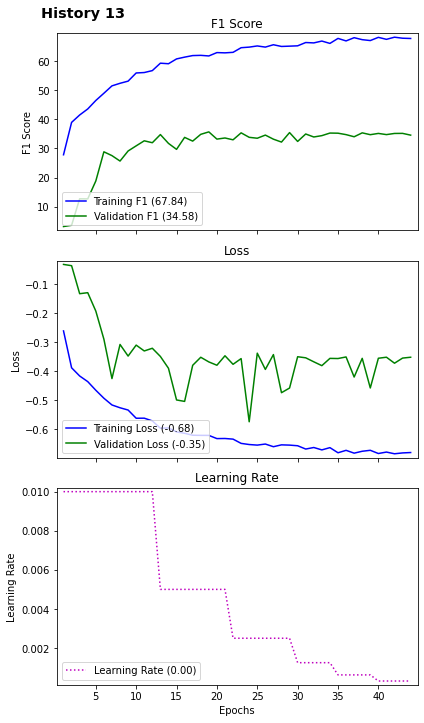

In [18]:
buff_dist = 2

em_target = 14

print("Beginning Iteration, Target steps:", em_target)
if EM_iterator > 0: print("Current Step:", EM_iterator)

# -----------------------------------------------------------------------------
# Begin Iteration -------------------------------------------------------------
while EM_iterator < em_target: # Note: using while loop to enable additional runs after test conclusion
    
    # 0. Initialization
    # ---------------------------
    step_start = time.perf_counter()

    # Create folder for em step
    emfolder = os.path.join(test_dir, 'Step_{:02}'.format(EM_iterator))
    if not os.path.exists(emfolder): os.mkdir(emfolder)

    print("\nEM Step {:02} begun.".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))

    
    # 1. Update Annotations
    # ---------------------------

    # 1.1 Get probability output map from last model 
    if (EM_iterator == 0) and seg_class_map_fp:
        # If on the first EM step, we load from previous data
        class_map_start = time.perf_counter()
        pmap_fp = os.path.join(emfolder, 'pmap_baseline.tif')
        kt.Get_Pmap(train_raster, model, pmap_fp)
        predicted_class_map = rio.open(seg_class_map_fp)
    else:
        # On every other EM step we take the pmap from the last model 
        class_map_start = time.perf_counter()
        pmap_fp = os.path.join(emfolder, 'pmap_{:02}.tif'.format(EM_iterator))
        predicted_class_map = kt.Get_Pmap(train_raster, model, pmap_fp)
        
    print("\nGenerated Predicted Class and Intermediate Feature Maps from previous model. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    
        
    # 1.2 Update annotation
    update_start = time.perf_counter()
    annotation_fp = os.path.join(emfolder, 'annotation_{:02}.shp'.format(EM_iterator))
    new_annotation = annotator.update_gdf_from_preload(all_data, class_map=predicted_class_map, out_path=annotation_fp) 

    # 1.3 Generate and save all considered point groups
    candidate_start = time.perf_counter()
    candidate_fp = os.path.join(emfolder, 'candidates_{:02}.shp'.format(EM_iterator))
    annotator.get_candidates(source_annotation, class_map=predicted_class_map, out_path=candidate_fp)
    
    # 1.5 Save iou for this annotation.
    iou_start = time.perf_counter()
    anno_iou = gt.gdf_iou(gt_labels, new_annotation, iou_buffer)


    print("\nCreated New Annotation. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))


    # 2. Create new Label Tensors
    # ---------------------------
    
    # 2.1 Rasterize New Labels
    rasterize_start = time.perf_counter()
    buff_anno = gt.gdf_buffer(new_annotation, buff_dist=buff_dist, flatten=True)
    anno_raster_fp = os.path.join(emfolder, 'rasterized_annotation_{:02}.tif'.format(EM_iterator))
    anno_raster = gt.GDF_Rasterize(buff_anno, train_raster, out_path=anno_raster_fp)
    
    # 2.2 Read Y_train, Y_val
    sample_tensor_start = time.perf_counter()
    Y_train = tile.ResampleTiles(anno_raster, train_offsets_fp)
    Y_val = tile.ResampleTiles(anno_raster, val_offsets_fp)
    
    # 2.2 Augment Y_train, Y_val
    Y_train = tile.AugmentImages(Y_train)
    Y_val = tile.AugmentImages(Y_val)
    
    print("\nCreated Y_train {} and Y_val {}. (Step {:02})".format(Y_train.shape, Y_val.shape, EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    
    
    # 3. Re-Train U-Net 
    # ---------------------------
    
    # 3.1 Load Callbacks 
    weight_path = os.path.join(emfolder, 'unet_weights_{:02}.h5'.format(EM_iterator))
    tensorboard_path = os.path.join(emfolder, 'tensorboard_{:02}'.format(EM_iterator))
    callbacks =  kt.SetCallbacks(weights_out = weight_path, es_patience = es_patience, rlop_factor = rlop_factor, tensorboard_path = tensorboard_path)#kt.SetCallbacks(emfolder + '/{}_{:02}.h5'.format(model_key, EM_iterator))
    
    # 3.2 Determine Learning Rate from internal oscilator
    EM_learning_rate = learning_rate #lr_schedule(learning_rate, EM_iterator, em_target)
    print("\nNew Learning Rate: {:.6f}. (Step {:02})".format(EM_learning_rate, EM_iterator))
    
    # 3.3 Train Model
    
    model_training_start = time.perf_counter()
    if use_gpu:
        with mirror_strategy.scope():
            model = kt.Get_Model('UNET')
            model.compile(optimizer=Adam(lr=EM_learning_rate, epsilon=adam_epsilon, decay=adam_decay), loss=kt.dice_coef_loss, metrics=metrics)
            print("\nTraining model...")
            training_history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=callbacks, verbose=0)
    else:
        model = kt.Get_Model('UNET')
        model.compile(optimizer=Adam(lr=EM_learning_rate, epsilon=adam_epsilon, decay=adam_decay), loss=kt.dice_coef_loss, metrics=metrics)
        print("\nTraining model...")
        training_history = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), shuffle=True, batch_size=batch_size, epochs=epochs, callbacks=callbacks, verbose=0)
    
     
    
    print("Completed model Training. (Step {:02})".format(EM_iterator))
    print(dt.now().strftime('%a at %I:%M:%S%p'))
    


    # 4. Evaluate Model
    # ---------------------------
    
    evaluate_start = time.perf_counter()

    # Save History Plots and CSV
    doc.plot_history(training_history, test_dir=emfolder, config_idx = EM_iterator)
    
    hist_markdown_fp = os.path.join(emfolder, 'history_{:02}.md'.format(EM_iterator))
    hist_md = open(hist_markdown_fp, 'w+')
    
    # Each of the reports below contains a dict with 'F1_Score', 'Dice' and their original floats
    test_rpt = kt.ModelReport(X_test, Y_test, model, "Testing", index=(EM_iterator+1), report_md=hist_md)
    train_rpt = kt.ModelReport(X_train, Y_train, model, "Training", index=(EM_iterator+1), report_md=hist_md)
    val_rpt = kt.ModelReport(X_val, Y_val, model, "Validation", index=(EM_iterator+1), report_md=hist_md)
    
    hist_md.close()
    
    evaluate_end = time.perf_counter()
    
    # Update reference dict
    em_dict['Name'].append('Step {:02}'.format(EM_iterator))
    em_dict['Line_IoU'].append(np.round((anno_iou*100), 2))
    
    em_dict['Test_Data'].append(test_rpt)
    em_dict['Train_Data'].append(train_rpt)
    em_dict['Val_Data'].append(val_rpt)
        
    em_dict['Epochs'].append(len(training_history.history['accuracy']))
    em_dict['LR'].append(EM_learning_rate)
    em_dict['Update_Time'].append('{:.3f} s'.format(candidate_start - update_start))
    em_dict['Training_Time'].append('{:.3f} s'.format(evaluate_start - model_training_start))
    
    
    # Update top values
    ### f1 score
    if test_rpt['F1_Score'] > top_f1:
        top_f1 = test_rpt['F1_Score']
        top_f1_idx = EM_iterator
        print("\nNew Top F1: {:.2f}".format(top_f1*100))
    ### Annotation IoU
    if np.round((anno_iou*100), 2) > top_iou:
        top_iou = np.round((anno_iou*100), 2)
        top_iou_idx = EM_iterator
        print("\nNew Top IoU: {:.2f}".format(top_iou))
    
    # Print step data
    print("\nEM Step ({:02}) Complete on {}".format(EM_iterator, dt.now().strftime('%a at %I:%M:%S%p')))
    print('- Annotation IoU:     {:.2f}'.format(anno_iou*100))
    print('\t- Source Improvement: {:+.2f}'.format((anno_iou-source_iou)*100))
    print('\t- Step Improvement:   {:+.2f}'.format((anno_iou-prev_iou)*100))
    print()
    print("------ Times ---------------------")
    print("- Class Map Generation: {:.3f} s".format(update_start - class_map_start))
    print("- Annotation Update:    {:.3f} s".format(candidate_start - update_start))
    print("- Model Training:       {:.3f} s".format(evaluate_start - model_training_start))
    print("- Model Evaluation:     {:.3f} s".format(evaluate_end - evaluate_start))
    print("----------------------------------\n\n")
    
    # Increase iterator and save previous precision for step_delta
    EM_iterator += 1
    prev_iou = anno_iou
 
# Increase EM target for optional subsequent runs
em_target += 1

### Create Plots

/home/jiang-ws1/.virtualenvs/geo_errors/lib/python3.7/site-packages/ipykernel_launcher.py:56: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


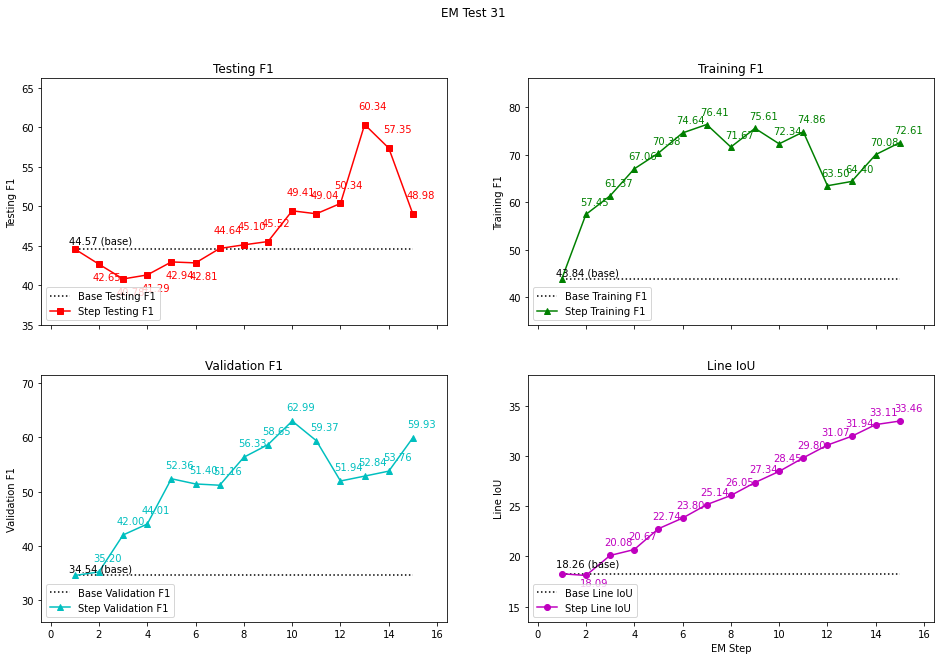

In [19]:
# Clean data for easy indexing

## Converts each of the report lists into a dict of lists for each value
model_dict = {'Test_Data': {}, 'Train_Data': {}, 'Val_Data': {}}
for em_key in model_dict.keys():
    for report in em_dict[em_key]:
        for rpt_key, rpt_value in [(key, item) for key, item in report.items()]:
            if rpt_key not in model_dict[em_key].keys():
                model_dict[em_key].update({rpt_key: np.array([rpt_value])})
            else:
                model_dict[em_key][rpt_key] = np.append(model_dict[em_key][rpt_key], report[rpt_key])


# Create Figure for Plots
fig, axs = plt.subplots(2, 2, sharex=True, figsize=(16,10))

## Plot Testing F1
doc.plot_axis(ax=axs[0,0], 
              data=model_dict['Test_Data']['F1_Score']*100, 
              name='Testing F1', 
              color_char='r', 
              symbol_char='s', 
              y_off=2,
              label_delta=False)

## Plot Training F1
doc.plot_axis(ax=axs[0,1], 
              data=model_dict['Train_Data']['F1_Score']*100, 
              name='Training F1', 
              color_char='g', 
              symbol_char='^', 
              y_off=2,
              label_delta=False)

## Plot Validation F1
doc.plot_axis(ax=axs[1,0], 
              data=model_dict['Val_Data']['F1_Score']*100, 
              name='Validation F1', 
              color_char='c', 
              symbol_char='^', 
              y_off=2,
              label_delta=False)

## Plot Annotation IoU
doc.plot_axis(ax=axs[1,1], 
              data=em_dict['Line_IoU'], 
              name='Line IoU', 
              color_char='m', 
              x_label='EM Step',
              label_delta=False)
    
## Title and show, and save figure
fig.suptitle("EM Test {:02}".format(test_idx))
fig_path = os.path.join(test_dir, 'test_{:02}_plot.png'.format(test_idx))
fig.savefig(fig_path)
fig.show()


### Save to Markdown

Saves:
- Annotator Config
- Model Config
- EM preformance table
- Model preformance table

In [ ]:
### Write test data to markdown
markdown_fp = os.path.join(test_dir, 'em_test_info_{:02}.md'.format(test_idx))
md = open(markdown_fp, 'w+')

# Header / Notes
md.write("# EM Test {:02}\n\n".format(test_idx))

if (len(test_notes) > 0):
    md.write("### Notes: \n")
    md.write(test_notes)

md.write(dt.now().strftime('\n%a at %I:%M:%S%p'))
    
md.write("\n\n---\n\n")

# prepare peak values
top_f1 = np.round((top_f1*100), 3)
source_f1 = np.round((em_dict['Test_Data'][0]['F1_Score']*100), 3)
source_iou = np.round(source_iou*100, 2)

# Note at top the peak values 
md.write("### Top Values:\n\n")
md.write(" - Testing F1 Score: **{:.2f}** (`{:+.2f}`) - Step {:02}\n".format(top_f1, (top_f1-source_f1), top_f1_idx))
md.write(" - Annotation IoU: **{:.2f}** (`{:+.2f}`) - Step {:02}\n\n\n".format(top_iou, (top_iou-source_iou), top_iou_idx))



# Test Configuration Section
md.write("## **Test Config**\n\n")

md.write("### Seeds:\n")
md.write("`Python`: {}, `Numpy`: {}, `Tensorflow`: {}\n\n".format(py_seed, np_seed, tf_seed))

md.write("### Annotator:\n")
for key, item in annotator.__dict__.items():
    
    # Skip gross keys
    if key in ['verbosity', 'crop_window', 'class_map', 'kwargs_key', 'crs']:
        continue
    
    # Write key and item
    md.write("- `{}`: {}\n".format(key, item))
        
md.write("\n\n")

md.write("### Model:\n")
md.write("- **Training**:\n")
md.write("  - `Batch Size`: {}\n".format(batch_size))
md.write("  - `Learning Rate`: {}\n".format(learning_rate))
md.write("  - `Epochs`: {}\n".format(epochs))
md.write("- **Callbacks**:\n")
md.write("  - `ES Patience`: {}\n".format(es_patience))
md.write("  - `RLOP Factor`: {}\n".format(rlop_factor))
md.write("  - `Adam Epsilon`: {}\n".format(adam_epsilon))
md.write("  - `Adam Decay`: {}\n".format(adam_decay))

md.write("\n\n")

md.write("### Other:\n")
md.write("- EM Steps: {}\n".format(em_target))
md.write("- ClassMap: '{}'\n".format(seg_class_map_fp))


md.write("\n---\n\n")


# Results Section

md.write("## **Results**:\n\n")

md.write("### EM Iteration:\n\n")

md.write("Step | Anno IoU | F1 | Epochs | LR | Train | Update\n")
md.write("---- | -------- | -- | ------ | -- | ----- | ------\n")
for idx in range(em_target):
    if idx == 0:
        md.write("{} | {} | {} | {} | {} | {} | {}\n".format(em_dict['Name'][idx], em_dict['Line_IoU'][idx], em_dict['Test_Data'][idx]['F1_Score'], em_dict['Epochs'][idx], em_dict['LR'][idx], em_dict['Training_Time'][idx], em_dict['Update_Time'][idx]))
    else:
        md.write("{} | {} (`{:+.2f}`) | {} | {} | {} | {} | {}\n".format(em_dict['Name'][idx], em_dict['Line_IoU'][idx], (em_dict['Line_IoU'][idx] - em_dict['Line_IoU'][0]), em_dict['Test_Data'][idx]['F1_Score'], em_dict['Epochs'][idx], em_dict['LR'][idx], em_dict['Training_Time'][idx], em_dict['Update_Time'][idx]))

md.write("\n\n</br>\n\n")
    
md.write("### Model Performance:\n\n")
md.write("Step | Test F1 | Test (FP, FN) | Train F1 | Train (FP, FN) | Val F1 | Val (FP, FN) | LR \n")
md.write("---- | ------- | ------------- | -------- | -------------- | ------ | ------------ | -- \n")
for idx in range(em_target):
    # Create a string to hold this row's data
    row_string = "{} | ".format(em_dict['Name'][idx])
    
    # Iterate over F1 types
    for key in ['Test_Data', 'Train_Data', 'Val_Data']:
        
        if idx == 0:
            row_string += "{:.2f} | ({:.2e}, {:.2e}) | ".format(em_dict[key][idx]['F1_Score']*100, em_dict[key][idx]['False_Positives'], em_dict[key][idx]['False_Negatives'])
        else:
            row_string += "{:.2f} (`{:+.2f}`) | ({:.2e}, {:.2e}) | ".format(em_dict[key][idx]['F1_Score']*100, (em_dict[key][idx]['F1_Score']*100 - em_dict[key][0]['F1_Score']*100), em_dict[key][idx]['False_Positives'], em_dict[key][idx]['False_Negatives'])
      
    # After all sets have been added, append learning rate and newline
    row_string += "{}\n".format(em_dict['LR'][idx])
    md.write(row_string)


# Close Markdown
md.close()

print("Config and results written to markdown.")
print("Location:", markdown_fp)